**Name: Debangshu Bhattacharya**

**Roll: MDS201910**

In [ ]:
#importing necessary libraries
import os
import json
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import time
import pandas as pd

In [ ]:
#importing nltk library which is going to help with sentence and word tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#The library langdetect helps in detecting the language of a given text
!pip install langdetect
from langdetect import detect

     |████████████████████████████████| 983kB 7.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=0f93f697b1a09b78878867f34566010ab9387b963f265623491fd88bdbdbdd0c
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


### 1) Extracting text content from JSON encoded data and creating a text corpus

In [ ]:
wd = os.path.join('My Drive/NLP/')
raw_data_dir = os.path.join(wd,'pdf_json')
files = os.listdir(raw_data_dir)

N = len(files)
print ("There are %d files in our covid dataset" %(N))

There are 56628 files in our covid dataset


In [ ]:
# Helper code to extract text from a json file (same as the one provided)
def extract_text(filepath,output_as_list=False):
    '''
    Extract the text from the file path and
    index the content from paper_id, title, abstract and body_text fields
    Retuns - if output_as_list = True
                list of all the above values,
             else
                text of title, abstract and bodt_text
    '''

    file = open(filepath)
    body_text = ""
    abstract = ""
    title = ""
    paper_id = ""

    paper_content = json.load(file)

    #get the paper_id
    if 'paper_id' in paper_content:
        paper_id = paper_content['paper_id']
    #get the title, if available
    if 'title' in paper_content['metadata']:
        title = paper_content['metadata']['title']
    #get abstract.text, if available
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
    if 'body_text' in paper_content:
        for bt in paper_content['body_text']:
            body_text = body_text + bt['text']

    file.close()
    
    if output_as_list:
            return [paper_id,title.lower(),abstract.lower(),body_text.lower()]
    else:
        return (title + ' ' + abstract + ' ' + body_text + ' ').lower()

In [ ]:
#Reading a random file to test the extract text code for a random file
file_ind = np.random.randint(0, len(files))
f = files[file_ind]

filepath = os.path.join(raw_data_dir, f)
text = extract_text(filepath)

For each json file, I am extracting the text and adding to the corpus file. Since, separate documents are being separated by a "\n" character, I am additionally checking if "\n" character is present in the text document itself. Turns out no additional such "\n" were present in the document but if it was the code would have preprocessed the text by removing the "\n" character here itself before adding to the corpus.

In [ ]:
#Creating the corpus of text from the documents where each line contains the text of a particular document
def hasNewLine(text):
  #function to check if a text contains a newline character
  return (not re.search('\n',text)==None)

def create_corpus(files):
  #function to create a text corpus for a given set of files as input. In the text corpus, each document will be represented as a text in each line. 
  n = len(files)
  corpus = ''

  for i, f in tqdm(enumerate(files)):
    filepath = os.path.join(raw_data_dir,f)
    text = extract_text(filepath)

    #search if '\n' is present in the text extracted from document. If newline is present we remove newline as newline should be the separator between two documents in our corpus
    t = (re.search('\n',text))==None
    if not t:
      print ("Document %d with filename %s has a newline in its text which is preprocessed before creation of corpus" %(i, f))
      text = re.sub('\n','',text)

    if i==n-1: #for last document, we do not add a newline after adding that text to corpus else after adding a document text to corpus we add a new line as separator
      corpus = corpus + text
    else:
      corpus = corpus + text + '\n'

  return corpus

To have an idea about how much time it would require to extract the text from JSON files of the whole corpus, I ran the code to extract first 100 documents and it took 65 seconds. To extract the whole corpus which contains 56628 documents it would require about 10 hours if it extracted in the same speed. Also, due to poor internet connection, it could get disconnected anytime and so I extracted the documents in batches of size 10000. After extracting 6 batches, I merged them all together to get the required corpus.

In [ ]:
def create_corpus_batch(files, batch_start,batch_size,N):
  #function to return a text corpus for a batch where the batch size and the document index with which the batch is starting is passed as arguments to the function
  batch_end = batch_start + batch_size
  if batch_end > N:
    batch_end = N
  
  batch_files = files[batch_start:batch_end]
  corpus_batch = create_corpus(batch_files)
  return corpus_batch

In [ ]:
batch_size = 10000
current_start_ind = 0

corpus_batch1 = create_corpus_batch(files, batch_start = 0, batch_size = batch_size, N= N)

10000it [2:05:48,  1.32it/s]


In [ ]:
len(corpus_batch1.split('\n'))

10000

In [ ]:
batch1 = os.path.join(wd, 'corpus_batch1.txt')
with open(batch1, 'w') as f:
  f.write(corpus_batch1)


In [ ]:
current_start_ind = 10000
corpus_batch2 = create_corpus_batch(files, batch_start = current_start_ind, batch_size = batch_size, N= N)

batch2 = os.path.join(wd, 'corpus_batch2.txt')
with open(batch2, 'w') as f:
  f.write(corpus_batch2)


10000it [2:03:09,  1.35it/s]


In [ ]:
current_start_ind = current_start_ind + batch_size
corpus_batch3 = create_corpus_batch(files, batch_start = current_start_ind, batch_size = batch_size, N= N)

batch3 = os.path.join(wd, 'corpus_batch3.txt')
with open(batch3, 'w') as f:
  f.write(corpus_batch3)


10000it [2:02:15,  1.36it/s]


In [ ]:
current_start_ind = 30000
batch_size = 10000

corpus_batch4 = create_corpus_batch(files, batch_start = current_start_ind, batch_size = batch_size, N= N)

batch4 = os.path.join(wd, 'corpus_batch4.txt')
with open(batch4, 'w') as f:
  f.write(corpus_batch4)


10000it [16:17, 10.23it/s]


In [ ]:
current_start_ind = 40000
batch_size = 10000

corpus_batch5 = create_corpus_batch(files, batch_start = current_start_ind, batch_size = batch_size, N= N)

batch5 = os.path.join(wd, 'corpus_batch5.txt')
with open(batch5, 'w') as f:
  f.write(corpus_batch5)

10000it [56:17,  2.96it/s]


In [ ]:
current_start_ind = 50000
corpus_batch6 = create_corpus_batch(files, batch_start = current_start_ind, batch_size = batch_size, N= N)

batch6 = os.path.join(wd, 'corpus_batch6.txt')
with open(batch6, 'w') as f:
  f.write(corpus_batch6)

6628it [32:51,  3.36it/s]


In [ ]:
# Merging the batches of extracted texts to form our final corpus
corpus = ''
with open(os.path.join(wd,'corpus_batch1.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c + '\n'

with open(os.path.join(wd,'corpus_batch2.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c + '\n'

with open(os.path.join(wd,'corpus_batch3.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c + '\n'

with open(os.path.join(wd,'corpus_batch4.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c + '\n'

with open(os.path.join(wd,'corpus_batch5.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c + '\n'

with open(os.path.join(wd,'corpus_batch6.txt'),'r') as f:
  c = f.read()
  corpus = corpus + c

In [ ]:
len(corpus.split('\n'))

56628

In [ ]:
#saving the corpus
with open(os.path.join(wd, 'corpus.txt'),'w') as f:
  f.write(corpus)

## 2,3,4) Preprocessing steps:

### Remove all non english documents from corpus: 
Since, most of the documents are English, keeping non English documents in our corpus will arise to additional complexities while handling language generation model.
 Hence, for simplicity I am removing all non english documents as a preprocessing step.
### Preprocess the texts in the corpus using regex functions:

1. **Remove links from the corpus**: I am removing all links and htmls from the text in the corpus. This is necessary as html tags and links should not be included in the vocabulary.
2. **Remove parenthesis and anything between the parenthesis**: The assumption behind this is that anything given in parenthesis is extra information and hence can be removed. On this note, I am also removing the citations from the text which are included in third brackets.
3. **Remove apostrophe and quotes from the text**: Words containing apostrophe are problematic to handle while tokenization and hence I am removing the apostrophe sign from the word. I am also removing any text within quotes as this mostly relate to extra information.
4. **Remove extra spaces from text**: I found that there are places where there are extra spaces in the text. Also, after applying some preprocessing leads to extra spaces in the text. So , I am removing all extra spaces as a preprocessing step.
5. **Remove punctuations which does not form the end of the sentence and other special characters**: Here, I am removing all characters which may be dropped as they are not significant in the context of language generation. Considering these tokens in the vocabulary set is not desirable and hence, I am removing these characters.
6. **Correcting sentence end structure according to sentence tokenization needs**: For sentence tokenization, I am using the sent_tokenize function of nltk which requires that a space is present after the sentence end punctuation ('.', '?' or '!'). In this corpus, I found that there are sentences where there is no space after the sentence end punctuations. Also, there are sentences where there is a space before the sentence end punctuation which can be removed. So, I am correcting this structure as the intermediate preprocessed corpus will be passed to the sentence tokenizer.


### Removing sentence end punctuation ('.', '?' or '!') and adding sentence separator token '\$\$\$\$' before and after each sentence:
As the final preprocessing step, I am tokenizing each sentence by nltk's sentence tokenizer function. Then I am removing the sentence end punctuations and am adding sentence separator '\$\$\$\$' before and after each sentence. This is justified as this pattern is not present in the corpus initially and hence adding this as separator will not cause any problems.







Reading the corpus which contains the text extracted from the json files of covid related articles.

In [ ]:
wd = os.path.join('My Drive/NLP/')
with open(os.path.join(wd, 'corpus.txt'),'r') as f:
  corpus = f.read()

In [ ]:
docs = corpus.split('\n')
N = len(docs)
print (N)

56628


Now, I am iterating over each document in the corpus and passing it into the lang detect library which detects the language of the text passed into it. I am removing all the documents which are identified as not English by this library.

In [ ]:
# removing non english words
eng_doc_indices = []

for i,doc in enumerate(tqdm(docs)):
  try:
    language = detect(doc)
    if language=='en':
      eng_doc_indices.append(i) 
  except:
    pass

 

100%|██████████| 56628/56628 [30:02<00:00, 31.41it/s]


In [ ]:
eng_docs = [docs[i] for i in eng_doc_indices]
len(eng_docs)

54941

In [ ]:
eng_corpus = '\n'.join(eng_docs)
len(eng_corpus.split('\n'))

54941

In [ ]:
#saving the english only corpus
with open(os.path.join(wd, 'eng_corpus.txt'),'w') as f:
  f.write(eng_corpus)

Reading the english corpus and preprocessing on it

In [ ]:
wd = os.path.join('My Drive/NLP/')
with open(os.path.join(wd, 'eng_corpus.txt'),'r') as f:
  corpus = f.read()

In [ ]:
docs = corpus.split('\n')
N = len(docs)
print (N)

54941


Helper functions used to preprocess the corpus texts. Each function is corresponding to the preprocessing on text steps describe above.

In [ ]:
def remove_url(text):
  # function to remove any urls from the text. It searches the regex pattern http(s):// or http(s):\\ followed by any set of characters unless it is a space, newline, enter, ' ', tab or ).
  pattern = re.compile(r'https?:/\/\.*[^\r\n\s\t\)]*')
  return re.sub(pattern, '', text)

def remove_parenthesis(text):
  # function to remove parenthesis and any characters appearing between the parenthesis in the text. It also removes citations which are represented by [].
  pattern = re.compile(r'[\[\(]+[^\n\[\(]*[\)\]]+')
  return re.sub(pattern, '', text)

def remove_apostrophe(text):
  #function to remove apostrophe and quotes from the text. The text contains apostrophes represented by \' and it also contains texts in quotes. For our purpose, I am removing both of these. 
  #removing '\s from text'
  t = re.sub('\'', '', text)
  return re.sub('[\"\']', '', t)

def remove_extra_space(text):
  #remove extra spaces and tabs to be just one white space. 
  pattern = re.compile(r'(?<= ) +')
  return re.sub(pattern, '', text)

def remove_characters(text):
  #remove punctuations which do not end a sentence: ',' ,';', ':'. Also remove special characters like #, $, %, &, >, <, =, +, -, *, /, @
  pattern = re.compile(r'[,:;#$%&><=*/\+\-\@]')
  return re.sub(pattern, '' , text)

def correct_sentence_end(text):
  #function to correct sentence structure. There should not be any whitespace before .,! or ?. 
  #There should be a whitespace after .! or ?. This is important to extract out sentences from a text. An extra regex code is used to handle decimals as there should not be space after decimal point.
  pattern1 = re.compile(r'( +)([.!?])')
  text = re.sub(pattern1, '\g<2>', text)
  pattern2 = re.compile(r'([?!])([^ ])')
  text = re.sub(pattern2, '\g<1>' + ' ' + '\g<2>', text)
  return re.sub('(\.)([^ \d])', '\g<1>' + ' ' + '\g<2>', text)



I am getting some memory error if I try to preprocess on the whole corpus at once. So, I am going to divide the corpus into 3 batches and preprocess the batches. I am storing each intermediate result and finally I am joining them altogether to get my preprocessed corpus.

In [ ]:
def read_batch(docs, batch_start, batch_end):
  #function to return a batch of documents from the corpus
  batch = docs[batch_start:batch_end]
  batch_text = '\n'.join(batch)
  return batch_text

In [ ]:
batch = read_batch(docs, 0, 20000)
print (len(batch.split('\n')))

20000


In [ ]:
def preprocess_batch(text):
  #function return a preprocessed batch of documents. The input to the function is the text of the batch of documents.
  
  # 1) remove urls
  #text = re.sub('https?:/\/\.*[^\r\n\s\t\)]*', '', text)
  text = remove_url(text)
  print ("Step 1 done")
  
  print (len(text.split('\n')))
  
  # 2) remove anything in parenthesis: Assumption things in parenthesis are extra information. 
  #Removing them should not harm us. Anything within [] are references and can be removed.
  #text = re.sub('[\[\(]+[^\[\(]*[\)\]]+', '', text)
  text = remove_parenthesis(text)
  print ("Step 2 done")
  print (len(text.split('\n')))

  # 3) Remove "\'" and quote
  '''text = re.sub('\'', '', text)
  text = re.sub('[\"\']','', text)'''
  text = remove_apostrophe(text)
  print ("Step 3 done")
  print (len(text.split('\n')))
  # 4) Remove commas, colons, semi-colons and special character $, #, %, &
  #text = re.sub('[, : ; # $ % & > < = * / + - @]', '', text)
  text = remove_characters(text)
  print ("Step 4 done")
  print (len(text.split('\n')))
  # 5) Remove extra spaces, tabs, spaces before 
  #text = re.sub('\s\s+', ' ', text)
  text = remove_extra_space(text)
  print ("Step 5 done")
  print (len(text.split('\n')))
  # 6) Sometimes there is a space before end of a sentence and no space after end of a sentence. Correcting structure
  text = correct_sentence_end(text)
  print ("Step 6 done")
  print (len(text.split('\n')))
  return text

In [ ]:
start = time.time()
preprocessed_batch = preprocess_batch(batch)
end = time.time()

print ("Time taken to preprocess batch 1 = %.3f minutes" %((end-start)/60))
print (len(preprocessed_batch.split('\n')))

Step 1 done
20000
Step 2 done
20000
Step 3 done
20000
Step 4 done
20000
Step 5 done
20000
Step 6 done
20000
Time taken to preprocess batch 1 = 1.491 minutes
20000


In [ ]:
with open(os.path.join(wd,'preprocess1.txt'),'w') as f:
  f.write(preprocessed_batch)

In [ ]:
del batch, preprocessed_batch

In [ ]:
batch = read_batch(docs, 20000, 40000)
print (len(batch.split('\n')))
start = time.time()
preprocessed_batch = preprocess_batch(batch)
end = time.time()

print ("Time taken to preprocess batch 2 = %.3f minutes" %((end-start)/60))
print (len(preprocessed_batch.split('\n')))

20000
Step 1 done
20000
Step 2 done
20000
Step 3 done
20000
Step 4 done
20000
Step 5 done
20000
Step 6 done
20000
Time taken to preprocess batch 2 = 1.522 minutes
20000


In [ ]:
with open(os.path.join(wd,'preprocess2.txt'),'w') as f:
  f.write(preprocessed_batch)

In [ ]:
del batch, preprocessed_batch

In [ ]:
batch = read_batch(docs, 40000, N)
start = time.time()
preprocessed_batch = preprocess_batch(batch)
end = time.time()

print ("Time taken to preprocess batch 3 = %.3f minutes" %((end-start)/60))

Step 1 done
14941
Step 2 done
14941
Step 3 done
14941
Step 4 done
14941
Step 5 done
14941
Step 6 done
14941
Time taken to preprocess batch 3 = 1.051 minutes


In [ ]:
with open(os.path.join(wd,'preprocess3.txt'),'w') as f:
  f.write(preprocessed_batch)

In [ ]:
del batch, preprocessed_batch

In [ ]:
wd = os.path.join('My Drive/NLP/')
with open(os.path.join(wd, 'preprocess1.txt'), 'r') as f:
  batch1 = f.read()

with open(os.path.join(wd, 'preprocess2.txt'), 'r') as f:
  batch2 = f.read()

with open(os.path.join(wd, 'preprocess3.txt'), 'r') as f:
  batch3 = f.read()

temp_corpus = batch1 + '\n' + batch2 + '\n'  + batch3

In [ ]:
docs = temp_corpus.split('\n')
N = len(docs)
print (N)

54941


Finally, I will remove the sentence end punctuation and add sentence separator token between sentences to the preprocessed corpus. While doing this, I am also going to compute the word count and sentence count of the preprocessed corpus. 

In [ ]:
WORD_COUNT = 0
SENTENCE_COUNT = 0
VOCAB = {}
T = []
M = []

In [ ]:
'''For each document in the corpus, I am tokenizing the sentences. For each sentence I am tokenizing the words and keeping track of the word and token count and the vocabulary.
I am also appending the sentence separator ($$$$) before and after each sentence to form our final preprocessing. 
'''
preprocessed_docs = []

for i,preprocessed_doc in enumerate(tqdm(docs)):
    sentences = sent_tokenize(preprocessed_doc)
    SENTENCE_COUNT += len(sentences)

    temp = ''
    for sentence in sentences:
      sentence = sentence[:-1] #not including the sentence end punctuation ('.', '?', or '!)
      
      tokens = word_tokenize(sentence)
      temp = temp + '$$$$' + sentence + '$$$$'
      
      for token in tokens:
        WORD_COUNT +=1
        VOCAB[token] = VOCAB.get(token,0) + 1

        #note down token count and vocab count in intervals of 10000
        if ((WORD_COUNT%10000)==0):
          T.append(WORD_COUNT)
          M.append(len(VOCAB.keys()))

    preprocessed_docs.append(temp)

100%|██████████| 54941/54941 [43:16<00:00, 21.16it/s]


In [ ]:
del temp_corpus

In [ ]:
del docs

In [ ]:
preprocessed_corpus = '\n'.join(preprocessed_docs)
with open(os.path.join(wd,'preprocessed_corpus.txt'),'w') as f:
  f.write(preprocessed_corpus)

Saving the token count and vocab count values in intervals of 10000 token counts.

In [ ]:
import pandas as pd
df = pd.DataFrame({'T':T, 'M':M})
df.to_csv(os.path.join(wd, 'T_M.csv'),index = False)

### 5) Size of Corpus

In [ ]:
print ("Word count = %d" %WORD_COUNT)
print ("Sentence count = %d" %SENTENCE_COUNT)

Word count = 205245580
Sentence count = 8802703


### 6) Vocabulary Size

In [ ]:
print ("Vocab size = %d" %len(VOCAB.keys()))

Vocab size = 1517373


### 7) Terms vs Vocab graph

In [ ]:
wd = os.path.join('My Drive/NLP/')
df = pd.read_csv(os.path.join(wd, 'T_M.csv'))

T = df['T'].values
M = df['M'].values

The lists T and M contains the token counts and vocabulary counts at intervals of 10000 tokens.

To estimate the parameters of Heap's law estimate, $M = kT^b$, i.e, $log_{10}M = log_{10}k + b*log_{10}T$,  two points of T and M are sufficient.

So, I am taking the value of T and M at token count of 10000 and 50000 respectively. From that I am getting the values of k and b. Using that I am estimating the value of M for each value of T. 

For plotting purpose, I am comparing the plots of $log_{10}M(actual)$ vs $log_{10}T$ and $log_{10}M(estimated)$ vs $log_{10}T$.

In [ ]:
#estimating heap's law parameters from two points  of (log(T), log(M)) and using heap's law to estimate the log(M) values for the rest.

log_T = np.log10(T)
log_M = np.log10(M)

x1 = log_T[0]
x2 = log_T[4]
y1 = log_M[0]
y2 = log_M[4]

#heap's law: log(M) = log(k) + blog(T)
b = (y2-y1)/(x2-x1)
log_k = y2 - (b*x2)

def heap_estimate(log_t, log_k, b):
  return (log_k + (b*log_t))
       

In [ ]:
estimated = [heap_estimate(x, log_k, b) for x in log_T]

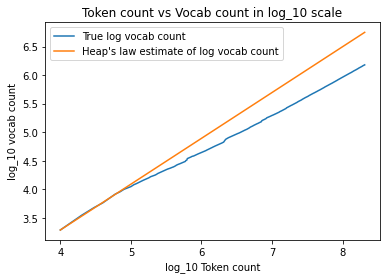

In [ ]:
plt.plot(log_T, log_M, label = "True log vocab count")
plt.plot(log_T, estimated, label = "Heap's law estimate of log vocab count")
plt.xlabel("log_10 Token count")
plt.ylabel("log_10 vocab count")
plt.title("Token count vs Vocab count in log_10 scale")
plt.legend()
plt.show()